In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np

Loading Dataset

In [57]:
image_size = 64
channels_img = 3
batch_size = 512

transform = transforms.Compose(
    [
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(channels_img)], [0.5 for _ in range(channels_img)]
        ),
    ]
)

dataset = datasets.CIFAR10(root="dataset/", transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified


Generator and Discriminator 

In [52]:
class Generator(nn.Module):
    def __init__(self, latent_dim, output_channels):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim

        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)
    
class Discriminator(nn.Module):
    def __init__(self, input_channels):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)
    
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [ ]:
def train(netD, netG, dataloader, num_epochs, criterion, optimizerD, optimizerG, device, channels_noise):
    loss_d = []
    loss_g = []

    for epoch in range(num_epochs):
        for batch_idx, (data, _) in enumerate(dataloader):
            data = data.to(device)
            batch_size = data.shape[0]
            netD.zero_grad()
            output = netD(data).reshape(-1)
            label = torch.ones_like(output)

            lossD_real = criterion(output, label)
            noise = torch.randn(batch_size, channels_noise, 1, 1).to(device)
            fake = netG(noise)
            output = netD(fake.detach()).reshape(-1)
            lossD_fake = criterion(output, torch.zeros_like(output))

            lossD = lossD_real + lossD_fake
            lossD_real.backward()
            lossD_fake.backward()
            optimizerD.step()

            netG.zero_grad()
            output = netD(fake).reshape(-1)
            lossG = criterion(output, torch.ones_like(output))
            lossG.backward()
            optimizerG.step()

            loss_d.append(lossD.item())
            loss_g.append(lossG.item())

            if batch_idx % 50 == 0:
                print('[%d/%d][%d/%d]\td_loss: %.4f\tg_loss: %.4f'
                    % (epoch, num_epochs, batch_idx, len(dataloader),
                        lossD.item(), lossG.item()))
                
    return loss_d, loss_g

In [58]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
latent_dim = 100
num_epochs = 10

netG = Generator(latent_dim, channels_img).to(device)
netD = Discriminator(channels_img).to(device)

initialize_weights(netG)
initialize_weights(netD)

lr = 0.0002
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerC = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))

loss_d, loss_g = train(netD, netG, dataloader, num_epochs, criterion, optimizerD, optimizerC, device, latent_dim)

[0/10][0/98]	d_loss: 1.3915	g_loss: 0.7280
[0/10][50/98]	d_loss: 0.1000	g_loss: 3.0693
[1/10][0/98]	d_loss: 0.0314	g_loss: 4.2493
[1/10][50/98]	d_loss: 0.2022	g_loss: 3.2961
[2/10][0/98]	d_loss: 0.0251	g_loss: 5.1578
[2/10][50/98]	d_loss: 0.2441	g_loss: 3.5799
[3/10][0/98]	d_loss: 0.0581	g_loss: 4.7067
[3/10][50/98]	d_loss: 0.0265	g_loss: 5.1503
[4/10][0/98]	d_loss: 0.2380	g_loss: 3.9896
[4/10][50/98]	d_loss: 0.3665	g_loss: 4.6491
[5/10][0/98]	d_loss: 0.2790	g_loss: 3.9450
[5/10][50/98]	d_loss: 0.4046	g_loss: 3.3818
[6/10][0/98]	d_loss: 0.3753	g_loss: 3.1228
[6/10][50/98]	d_loss: 1.2682	g_loss: 2.5694
[7/10][0/98]	d_loss: 0.4076	g_loss: 2.7472
[7/10][50/98]	d_loss: 0.8064	g_loss: 2.2093
[8/10][0/98]	d_loss: 1.1124	g_loss: 2.9052
[8/10][50/98]	d_loss: 0.7539	g_loss: 1.8153
[9/10][0/98]	d_loss: 0.8998	g_loss: 2.1901
[9/10][50/98]	d_loss: 1.1688	g_loss: 2.0940


Loss vs Epoch

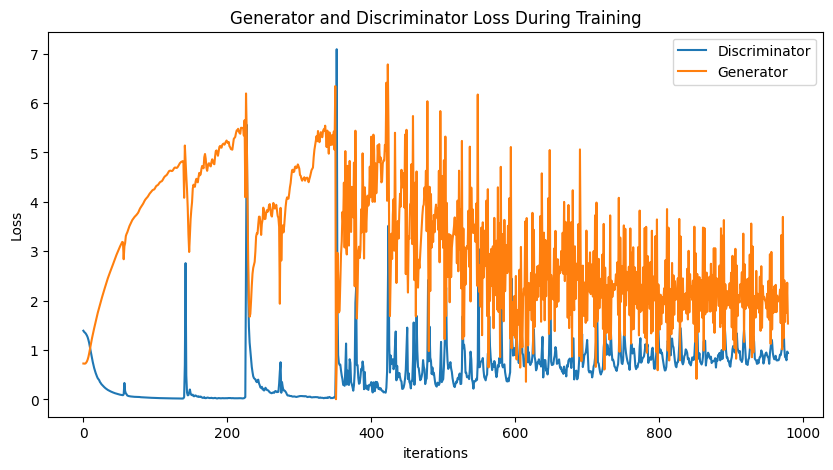

In [59]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(loss_d, label="Discriminator")
plt.plot(loss_g, label="Generator")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

Generating images

In [60]:
noise = torch.randn(10, latent_dim, 1, 1).to(device)
generated_images = netG(noise)
save_image(generated_images, "generated_images.png")